In [1]:
%config Completer.use_jedi = False

from utils import *
from parallel import to_run, findpos, find_relaxation, do_find_decorrelation_time,steps_needed_normalized

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib
from multiprocessing import Pool
from tqdm.notebook import tqdm
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 72
plt.rcParams["figure.figsize"] = [12,8]

from ising_model import SimulateMH

In [2]:
pool = Pool(4)

In [2]:
scale = 40*16
Ts=np.linspace(0,4.5,scale+1)[1:]

In [ ]:
results = []
for T in tqdm(Ts):
    res = do_find_decorrelation_time(
        T, 4,4,10**8,1,np.random.randint(0,1000000))
    results.append(res)

In [ ]:
#results = []
for Ts1 in tqdm(Ts[len(results):].reshape(-1,16)):
    runs = len(Ts1)
    res = pool.starmap(do_find_decorrelation_time, #T, N, M, steps
            zip(*(Ts1,
                  [64]*runs, # N
                  [64]*runs, # M
                  [10**9]*runs, # steps
                  [10]*runs, # steps
                  np.random.randint(0,1000000, runs), # seed
                      )),
#             chunksize=1
        )
    results+= res

In [5]:
with open("autocor-4-9.pkl","wb") as f:
    pickle.dump((Ts.flatten(), results), f)

In [8]:
len(results)

240

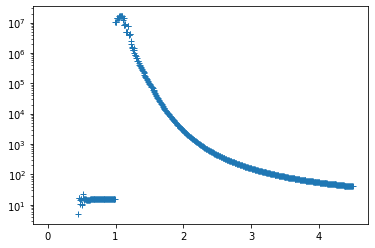

In [4]:
plt.plot(Ts.flatten()[:len(results)], results, "+")
plt.gca().set_yscale("log")

In [106]:
Mss = []
T = 3
N,M = 32,32
relax_steps = steps_needed(T)
steps = 10**8
freq = 1 # max(1,steps//10**4)

for _ in tqdm(range(1)):
    SEED = np.random.randint(100000000)
    _,_,Ms, Es, engine = to_run(1, steps+3*relax_steps, T=T, N=N, M=M, freq=freq, bc=1,
                            SEED=SEED, return_engine=True, 
                            init="random")
    Mss.append(Ms[-steps:])

In [107]:
Mss = np.array(Mss)

In [88]:
Mss.shape

(1, 100000000)

In [12]:
N=4
M=4
T=1.0
steps_needed = int(steps_needed_normalized(T)*N*M)

In [16]:
steps=10**7
_,_,Ms, Es, engine = to_run(1, steps_needed*3+steps, T=T, N=N, M=M, freq=1, bc=1,
                            SEED=np.random.randint(1000000), return_engine=True, 
                            init="random")
Ms = Ms[-steps:]

In [28]:
dts = np.arange(1,100)
# dts = np.linspace(1,100, 100).astype(int)
autocor = []
autocor_err = []
Ms1 = Ms - Ms.mean()
var = Ms.var()
for dt in tqdm(dts):
    mean, err = mean_with_err(Ms1[dt:] * Ms1[:-dt])
    autocor.append(mean/var)
    autocor_err.append(err/var)
autocor = np.array(autocor)
autocor_err = np.array(autocor_err)

In [29]:
find_decorrelation_time(Ms)

16

<ErrorbarContainer object of 3 artists>

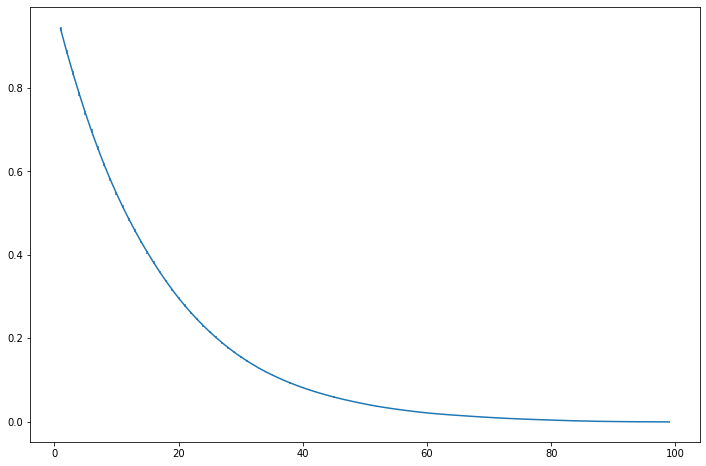

In [30]:
plt.errorbar(dts, autocor, yerr=autocor_err)

<ErrorbarContainer object of 3 artists>

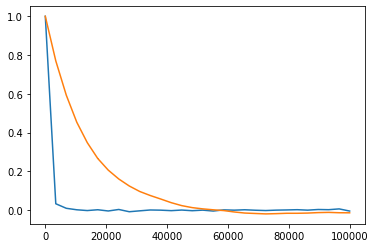

In [92]:
plt.errorbar(dts, autocor[0]/autocor[0][0], yerr=autocor_err[0]/autocor[0][0])
plt.errorbar(dts, autocor_T3[0]/autocor_T3[0][0], yerr=autocor_T3_err[0]/autocor_T3[0][0])

<ErrorbarContainer object of 3 artists>

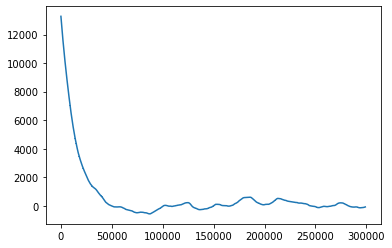

In [75]:
plt.errorbar(dts, autocor[0], yerr=autocor_err[0])

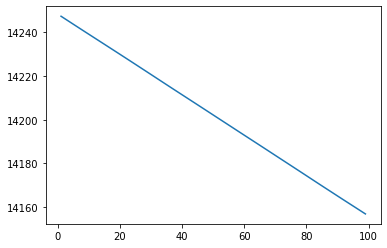

In [41]:
plt.plot(dts, autocor[2])

In [16]:
Ms_mean = np.mean(Ms)

In [17]:
Ms1 = Ms - Ms_mean

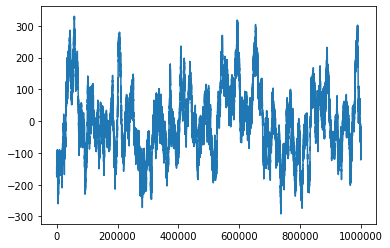

In [15]:
plt.plot(Ms)

In [35]:
with open("relaxations.pkl","rb") as f:
    results = pickle.load(f)

In [36]:
len(results)

84100

In [ ]:
def findpos(x, start=0):
    def findpos_rec(x, start=0):
        x1 = x[start:]

        mean = np.mean(x1)
        std = np.mean(x1)
        if mean < x[0]:
            mean = - mean
            x = -x
            x1 = -x1
        x2 = x1[x1>=mean]
        mean2 = np.mean(x2)

        #         print(np.where(x>mean2))
        return np.where(x>=mean2)[0][0]
    pos = [0]
    for _ in range(400):
        pos.append(findpos_rec(x, start=pos[-1]))
        if pos[-1]==pos[-2]:
            break
    return pos[-1]

In [38]:
df = pd.DataFrame(results, columns=["T",  "RTM_const", "RTE_const", "RTM_rand", "RTE_rand"])

In [39]:
gb = df.groupby("T")

In [40]:
dfmoments = pd.concat([
gb.mean().add_suffix("_mean"),
gb.std().add_suffix("_std")], axis=1)
dfm = dfmoments[sorted(dfmoments.columns)]

In [42]:
dfm.head()

,RTE_const_mean,RTE_const_std,RTE_rand_mean,RTE_rand_std,RTM_const_mean,RTM_const_std,RTM_rand_mean,RTM_rand_std
T,,,,,,,,
0.045,0.0,0.0,156233.083234,101965.191071,0.0,0.0,108092.258026,97134.962938
0.090,0.0,0.0,161680.202140,117349.768530,0.0,0.0,107544.884661,111024.153631
0.135,0.0,0.0,159884.136742,103570.159579,0.0,0.0,108817.123662,99283.685501
0.180,0.0,0.0,158341.505351,110329.560941,0.0,0.0,105817.594530,106013.854251
0.225,0.0,0.0,158370.552913,102814.365200,0.0,0.0,106921.608799,100432.744776


In [45]:
sprs=2

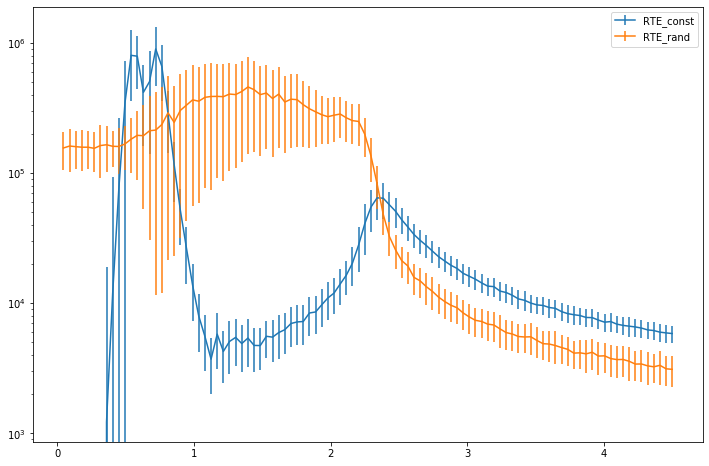

In [49]:
plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
plt.gca().set_yscale("log")
plt.legend()


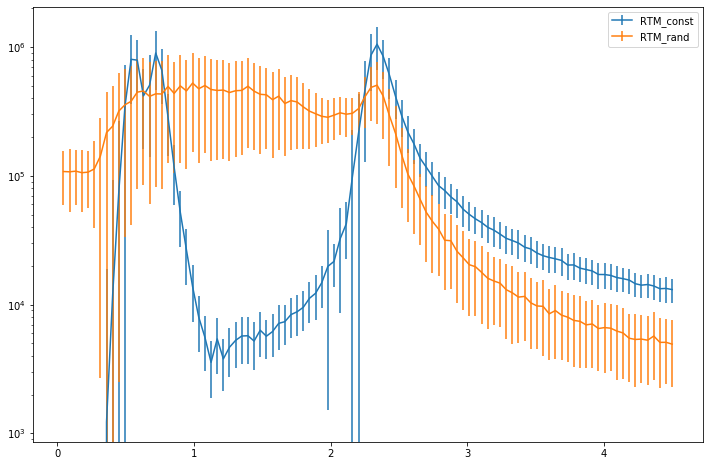

In [48]:
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log")
# plt.ylim(1,3*10**6)
plt.legend()

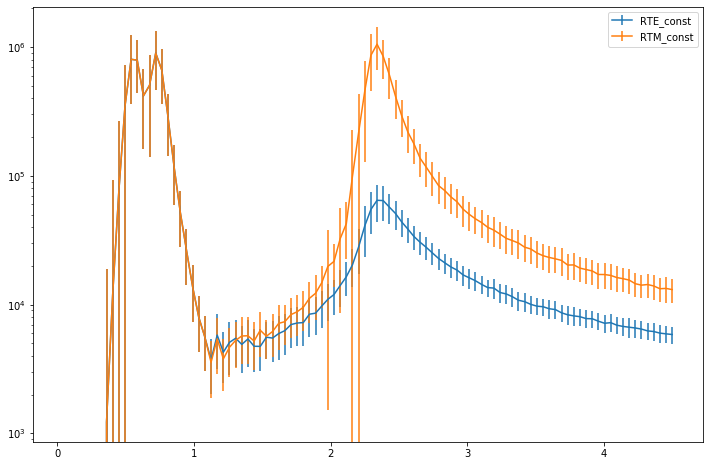

In [50]:
plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.gca().set_yscale("log")
plt.legend()

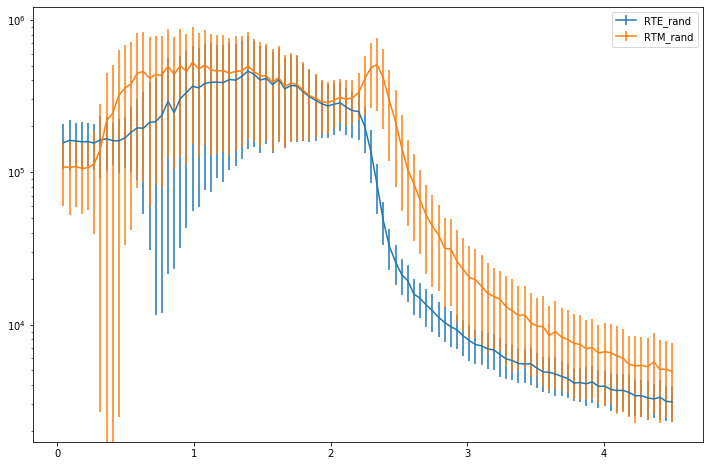

In [51]:
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log")
plt.legend()

/home/ashot/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


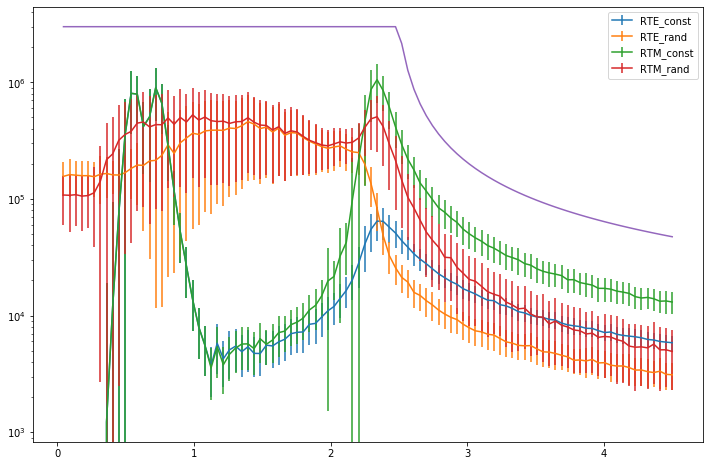

In [104]:
Ts1 = dfm.index.values
steps = np.ones_like(Ts1)*10**5
b=0.08
n=0.1
steps = np.exp(np.log(3*10**6)*(b/(b+Ts1-2.5))**n)
steps[Ts1<2.5] = 3*10**6
steps = steps.astype(int)



plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log")
# plt.xlim(2.5, 4.5)
# plt.ylim(0, 400000)
xs = dfm.index
plt.plot(xs, steps)
# plt.plot(xs, 400000 * np.exp((2.5/xs)))

plt.legend()


In [95]:
a,b = np.polyfit(x,y**-1, 1)

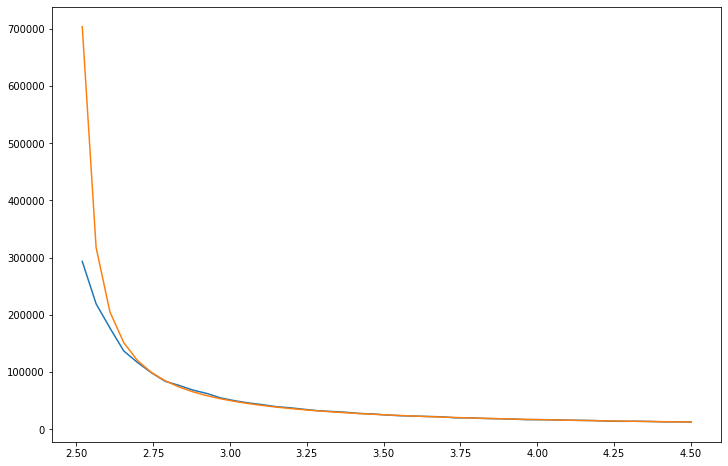

In [97]:
# plt.plot(dfm.index[dfm.index>2.5], dfm.RTM_const_mean[dfm.index>2.5]**-1)
x, y = dfm.index[dfm.index>2.5], dfm.RTM_const_mean[dfm.index>2.5]
# plt.plot(np.log(x),1/np.log(y))
# plt.plot(np.exp(-1/x),y**-1)
plt.plot(x, y)
plt.plot(x, 1/(a*x+b))
# plt.plot(dfm.index[dfm.index>2.5], 1/(a*dfm.index[dfm.index>2.5]+b))
# plt.xlim(2.5, 4.5)
# plt.ylim(0, 400000)

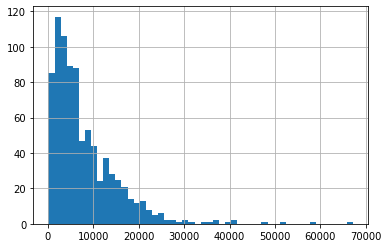

In [36]:
gb.get_group(1.035).RTM_const.hist(bins=50)